<a href="https://colab.research.google.com/github/Only-Space/gestur-tangan-huruf/blob/main/gestur_tangan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
import os
import zipfile

# Path ZIP dan lokasi ekstraksi
zip_path = "/content/drive/MyDrive/dataset/bisindo/dataset-bisindo-22k.zip"
extract_path = "/content/dataset"

# Ekstraksi jika folder belum ada
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset berhasil diekstrak ke:", extract_path)


Dataset berhasil diekstrak ke: /content/dataset


In [3]:
# Label mapping termasuk huruf Z
label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4,
    'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
    'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
    'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24,
    'Z': 25
}

inv_label_mapping = {v: k for k, v in label_mapping.items()}

RANDOM_SEED = 26
PATH_DATASET = "/content/dataset/bisindo"


In [4]:
from torchvision import transforms

# Nilai mean & std dataset
DATA_MEAN = (0.5,)
DATA_STD = (0.5,)

# Transformasi training dengan augmentasi
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])

# Transformasi validasi (tanpa augmentasi)
val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEAN, std=DATA_STD)
])


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Corrected paths - assuming images and labels are directly under train and val directories
PATH_TRAIN_IMG = os.path.join(PATH_DATASET, "images/train")
PATH_VAL_IMG = os.path.join(PATH_DATASET, "images/val")

PATH_TRAIN_LABEL = os.path.join(PATH_DATASET, "images/train") # Assuming labels are in the same directories as images
PATH_VAL_LABEL = os.path.join(PATH_DATASET, "images/val")   # Assuming labels are in the same directories as images

class BISINDODataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir # This might not be needed if labels are inferred from image paths
        self.transform = transform
        self.data = []

        # Modify to iterate through class folders directly under img_dir
        for class_name in sorted(os.listdir(img_dir)):
            class_img_path = os.path.join(img_dir, class_name)
            # Assuming label_dir is the same structure, can infer label from class_name
            if os.path.isdir(class_img_path) and class_name in label_mapping: # Check if it's a directory and a valid label
                 for img_file in os.listdir(class_img_path):
                    img_path = os.path.join(class_img_path, img_file)
                    # Assuming label is the class_name
                    self.data.append((img_path, label_mapping[class_name]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        # Convert to RGB to ensure 3 channels consistently before Grayscale transform
        image = Image.open(img_path).convert("RGB")


        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = BISINDODataset(PATH_TRAIN_IMG, PATH_TRAIN_LABEL, transform=train_transform)
val_dataset = BISINDODataset(PATH_VAL_IMG, PATH_VAL_LABEL, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Total data train: {len(train_dataset)}")
print(f"Total data val: {len(val_dataset)}")

Total data train: 9169
Total data val: 2301


In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Changed input channels to 1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
        )

        # Calculate the correct input size for the linear layer
        # Based on 28x28 input and three MaxPool2d layers with kernel_size=2, stride=2
        # 28 -> 14 -> 7 -> 3
        flattened_size = 128 * 3 * 3

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm # Untuk progress bar yang lebih baik

# -------------------------------------------------------------------------
# FUNGSI UNTUK TRAINING (SUDAH DIMODIFIKASI UNTUK MENCATAT HISTORY)
# -------------------------------------------------------------------------
def train_model(model, train_loader, val_loader, epochs, device):
    """
    Fungsi untuk melatih model dan mencatat riwayat loss & akurasi.
    """
    # Definisikan criterion dan optimizer di sini
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Siapkan list untuk menyimpan history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    print("🚀 Memulai Training...")
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Progress bar untuk training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", unit="batch")

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Update progress bar
            train_pbar.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", unit="batch")

        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                val_pbar.set_postfix(loss=loss.item())

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val

        # Simpan hasil epoch ini ke history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    return history


# -------------------------------------------------------------
# FUNGSI BARU UNTUK MEMBUAT PLOT GRAFIK
# -------------------------------------------------------------
def plot_metrics(history):
    """
    Fungsi untuk memvisualisasikan grafik loss dan akurasi.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Grafik Loss Model')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Grafik Akurasi Model')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.show()

In [8]:
!nvidia-smi

Fri Aug 29 12:35:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Menggunakan device: cuda:0
🔎 Checkpoint 'best_model.pth' tidak ditemukan. Training dari awal.
Memulai pelatihan selama 45 epoch...
🚀 Memulai Training...


Epoch 1/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.75batch/s, loss=1.26]


Epoch 1/45 | Train Loss: 2.9201 | Train Acc: 0.1360 | Val Loss: 1.8560 | Val Acc: 0.5211


Epoch 2/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.85batch/s, loss=0.948]


Epoch 2/45 | Train Loss: 2.0893 | Train Acc: 0.3541 | Val Loss: 1.2984 | Val Acc: 0.6741


Epoch 3/45 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.48batch/s, loss=0.623]


Epoch 3/45 | Train Loss: 1.7149 | Train Acc: 0.4845 | Val Loss: 1.0582 | Val Acc: 0.7053


Epoch 4/45 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.47batch/s, loss=0.378]


Epoch 4/45 | Train Loss: 1.4943 | Train Acc: 0.5562 | Val Loss: 0.9026 | Val Acc: 0.7510


Epoch 5/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.60batch/s, loss=0.376]


Epoch 5/45 | Train Loss: 1.3516 | Train Acc: 0.6027 | Val Loss: 0.8473 | Val Acc: 0.7514


Epoch 6/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.65batch/s, loss=0.491]


Epoch 6/45 | Train Loss: 1.2596 | Train Acc: 0.6320 | Val Loss: 0.8128 | Val Acc: 0.7610


Epoch 7/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.88batch/s, loss=0.318]


Epoch 7/45 | Train Loss: 1.1912 | Train Acc: 0.6529 | Val Loss: 0.7573 | Val Acc: 0.7753


Epoch 8/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.65batch/s, loss=0.318]


Epoch 8/45 | Train Loss: 1.1576 | Train Acc: 0.6618 | Val Loss: 0.7558 | Val Acc: 0.7714


Epoch 9/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.62batch/s, loss=0.495]


Epoch 9/45 | Train Loss: 1.1044 | Train Acc: 0.6741 | Val Loss: 0.7225 | Val Acc: 0.7801


Epoch 10/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.86batch/s, loss=0.231]


Epoch 10/45 | Train Loss: 1.0721 | Train Acc: 0.6816 | Val Loss: 0.7058 | Val Acc: 0.7818


Epoch 11/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  7.03batch/s, loss=0.271]


Epoch 11/45 | Train Loss: 1.0461 | Train Acc: 0.6909 | Val Loss: 0.6651 | Val Acc: 0.7940


Epoch 12/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.60batch/s, loss=0.3]


Epoch 12/45 | Train Loss: 1.0087 | Train Acc: 0.7001 | Val Loss: 0.6565 | Val Acc: 0.8001


Epoch 13/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.64batch/s, loss=0.255]


Epoch 13/45 | Train Loss: 1.0027 | Train Acc: 0.7025 | Val Loss: 0.6383 | Val Acc: 0.8049


Epoch 14/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.66batch/s, loss=0.224]


Epoch 14/45 | Train Loss: 0.9763 | Train Acc: 0.7098 | Val Loss: 0.6303 | Val Acc: 0.8070


Epoch 15/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  7.05batch/s, loss=0.204]


Epoch 15/45 | Train Loss: 0.9593 | Train Acc: 0.7135 | Val Loss: 0.6087 | Val Acc: 0.8101


Epoch 16/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.72batch/s, loss=0.217]


Epoch 16/45 | Train Loss: 0.9586 | Train Acc: 0.7155 | Val Loss: 0.6039 | Val Acc: 0.8062


Epoch 17/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.71batch/s, loss=0.288]


Epoch 17/45 | Train Loss: 0.9189 | Train Acc: 0.7269 | Val Loss: 0.6012 | Val Acc: 0.8127


Epoch 18/45 [Validation]: 100%|██████████| 72/72 [00:09<00:00,  7.45batch/s, loss=0.172]


Epoch 18/45 | Train Loss: 0.8857 | Train Acc: 0.7306 | Val Loss: 0.5895 | Val Acc: 0.8105


Epoch 19/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.71batch/s, loss=0.181]


Epoch 19/45 | Train Loss: 0.8918 | Train Acc: 0.7278 | Val Loss: 0.5777 | Val Acc: 0.8253


Epoch 20/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.69batch/s, loss=0.153]


Epoch 20/45 | Train Loss: 0.8861 | Train Acc: 0.7362 | Val Loss: 0.5632 | Val Acc: 0.8157


Epoch 21/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.71batch/s, loss=0.124]


Epoch 21/45 | Train Loss: 0.8653 | Train Acc: 0.7435 | Val Loss: 0.5561 | Val Acc: 0.8188


Epoch 22/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.71batch/s, loss=0.156]


Epoch 22/45 | Train Loss: 0.8345 | Train Acc: 0.7423 | Val Loss: 0.5479 | Val Acc: 0.8244


Epoch 23/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  7.09batch/s, loss=0.177]


Epoch 23/45 | Train Loss: 0.8372 | Train Acc: 0.7444 | Val Loss: 0.5484 | Val Acc: 0.8275


Epoch 24/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.73batch/s, loss=0.148]


Epoch 24/45 | Train Loss: 0.8300 | Train Acc: 0.7474 | Val Loss: 0.5301 | Val Acc: 0.8322


Epoch 25/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.64batch/s, loss=0.158]


Epoch 25/45 | Train Loss: 0.8096 | Train Acc: 0.7556 | Val Loss: 0.5192 | Val Acc: 0.8370


Epoch 26/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.57batch/s, loss=0.178]


Epoch 26/45 | Train Loss: 0.8111 | Train Acc: 0.7533 | Val Loss: 0.5157 | Val Acc: 0.8388


Epoch 27/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.78batch/s, loss=0.152]


Epoch 27/45 | Train Loss: 0.8072 | Train Acc: 0.7549 | Val Loss: 0.5123 | Val Acc: 0.8388


Epoch 28/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.94batch/s, loss=0.165]


Epoch 28/45 | Train Loss: 0.7724 | Train Acc: 0.7609 | Val Loss: 0.4957 | Val Acc: 0.8444


Epoch 29/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.57batch/s, loss=0.156]


Epoch 29/45 | Train Loss: 0.7531 | Train Acc: 0.7682 | Val Loss: 0.4840 | Val Acc: 0.8492


Epoch 30/45 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.45batch/s, loss=0.165]


Epoch 30/45 | Train Loss: 0.7538 | Train Acc: 0.7680 | Val Loss: 0.4894 | Val Acc: 0.8479


Epoch 31/45 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.50batch/s, loss=0.0944]


Epoch 31/45 | Train Loss: 0.7605 | Train Acc: 0.7658 | Val Loss: 0.4743 | Val Acc: 0.8462


Epoch 32/45 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.43batch/s, loss=0.127]


Epoch 32/45 | Train Loss: 0.7600 | Train Acc: 0.7644 | Val Loss: 0.4505 | Val Acc: 0.8557


Epoch 33/45 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.54batch/s, loss=0.107]


Epoch 33/45 | Train Loss: 0.7287 | Train Acc: 0.7741 | Val Loss: 0.4598 | Val Acc: 0.8583


Epoch 34/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  7.08batch/s, loss=0.0739]


Epoch 34/45 | Train Loss: 0.7412 | Train Acc: 0.7743 | Val Loss: 0.4507 | Val Acc: 0.8575


Epoch 35/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.61batch/s, loss=0.0609]


Epoch 35/45 | Train Loss: 0.7135 | Train Acc: 0.7817 | Val Loss: 0.4443 | Val Acc: 0.8618


Epoch 36/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.56batch/s, loss=0.106]


Epoch 36/45 | Train Loss: 0.7072 | Train Acc: 0.7842 | Val Loss: 0.4246 | Val Acc: 0.8674


Epoch 37/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.56batch/s, loss=0.0545]


Epoch 37/45 | Train Loss: 0.7083 | Train Acc: 0.7829 | Val Loss: 0.4362 | Val Acc: 0.8609


Epoch 38/45 [Validation]: 100%|██████████| 72/72 [00:09<00:00,  7.23batch/s, loss=0.0745]


Epoch 38/45 | Train Loss: 0.6925 | Train Acc: 0.7872 | Val Loss: 0.4280 | Val Acc: 0.8701


Epoch 39/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.58batch/s, loss=0.0334]


Epoch 39/45 | Train Loss: 0.6857 | Train Acc: 0.7889 | Val Loss: 0.4133 | Val Acc: 0.8644


Epoch 40/45 [Validation]: 100%|██████████| 72/72 [00:11<00:00,  6.39batch/s, loss=0.031]


Epoch 40/45 | Train Loss: 0.6819 | Train Acc: 0.7920 | Val Loss: 0.4129 | Val Acc: 0.8735


Epoch 41/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.62batch/s, loss=0.0399]


Epoch 41/45 | Train Loss: 0.6667 | Train Acc: 0.7929 | Val Loss: 0.3970 | Val Acc: 0.8753


Epoch 42/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.67batch/s, loss=0.0395]


Epoch 42/45 | Train Loss: 0.6662 | Train Acc: 0.7926 | Val Loss: 0.4098 | Val Acc: 0.8770


Epoch 43/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.88batch/s, loss=0.0114]


Epoch 43/45 | Train Loss: 0.6456 | Train Acc: 0.7974 | Val Loss: 0.3912 | Val Acc: 0.8805


Epoch 44/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.59batch/s, loss=0.0339]


Epoch 44/45 | Train Loss: 0.6536 | Train Acc: 0.8004 | Val Loss: 0.3925 | Val Acc: 0.8822


Epoch 45/45 [Validation]: 100%|██████████| 72/72 [00:10<00:00,  6.55batch/s, loss=0.042]


Epoch 45/45 | Train Loss: 0.6391 | Train Acc: 0.7993 | Val Loss: 0.3820 | Val Acc: 0.8866

🎉 Pelatihan selesai! Model final berhasil disimpan.

📈 Menampilkan grafik performa model...


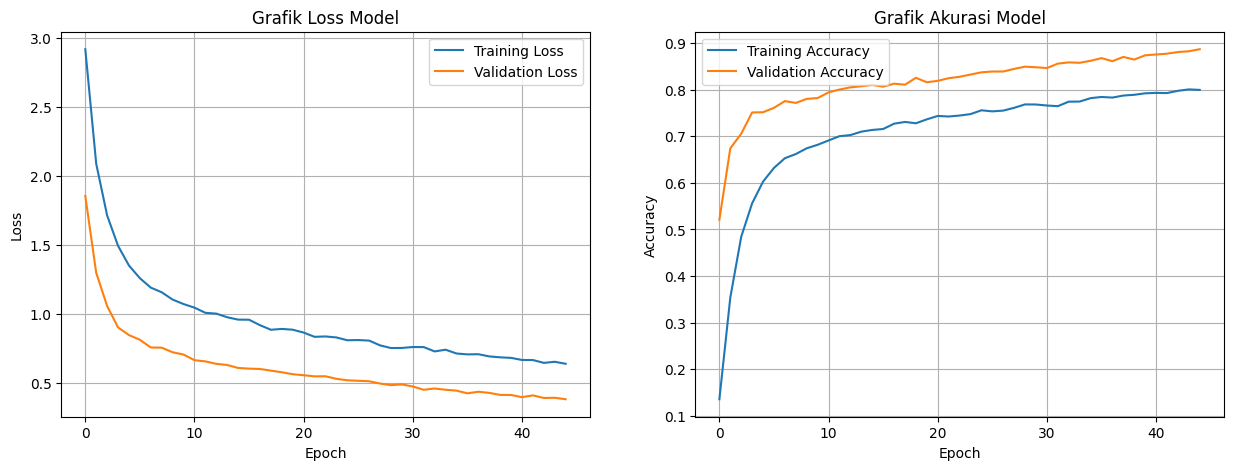

In [9]:
model = CNN(num_classes=26)
# Asumsikan Anda sudah mendefinisikan:
# - model = CNN(num_classes=26)
# - train_loader dan val_loader
# - os, torch, dll sudah di-import

# -----------------------------
# 1. Inisialisasi Model dan Device
# -----------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")
model.to(device)

# -----------------------------
# 2. Load Checkpoint (jika ada)
# -----------------------------
checkpoint_path = "best_model.pth"
if os.path.exists(checkpoint_path):
    try:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"✅ Bobot dari checkpoint '{checkpoint_path}' berhasil dimuat.")
    except Exception as e:
        print(f"❌ Gagal memuat checkpoint: {e}")
else:
    print(f"🔎 Checkpoint '{checkpoint_path}' tidak ditemukan. Training dari awal.")

# -----------------------------
# 3. Training Lanjutan & Simpan History
# -----------------------------
epochs = 45
print(f"Memulai pelatihan selama {epochs} epoch...")

# Panggil fungsi train_model dan simpan hasilnya di variabel 'training_history'
training_history = train_model(model, train_loader, val_loader, epochs, device)

# -----------------------------
# 4. Simpan Model Final
# -----------------------------
torch.save(model.state_dict(), "cnn_handsign_model_final.pth")
print("\n🎉 Pelatihan selesai! Model final berhasil disimpan.")

# -----------------------------
# 5. Visualisasi Hasil Training
# -----------------------------
print("\n📈 Menampilkan grafik performa model...")
plot_metrics(training_history)

In [10]:
def evaluate(model, loader, device='cuda'):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    incorrect_samples = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)

            correct += (preds == labels).sum().item()
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_samples.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))

    print(f"Accuracy: {100 * correct / total:.2f}%")
    return incorrect_samples

In [11]:
import os
import pandas as pd
from torch.utils.data import DataLoader

# Try lowercase 'test' first
PATH_TEST = os.path.join(PATH_DATASET, "images/val")

# If lowercase 'test' doesn't exist, try uppercase 'Test' (though less likely based on previous errors)
if not os.path.exists(PATH_TEST):
    PATH_TEST = os.path.join(PATH_DATASET, "images/val")

print(f"Attempting to load test data from: {PATH_TEST}")

# Define LABELS from the keys of label_mapping
LABELS = list(label_mapping.keys())

data_test = []
if os.path.exists(PATH_TEST):
    for label in LABELS:
        label_path = os.path.join(PATH_TEST, label)
        if not os.path.exists(label_path):
            print(f"Warning: {label_path} tidak ditemukan, dilewati.")
            continue
        for fname in os.listdir(label_path):
            full_path = os.path.join(label_path, fname)
            if os.path.isfile(full_path):
                data_test.append({
                    "label": label,  # Simpan string label
                    "full_path": full_path
                })
else:
    print(f"Error: Test data directory not found at {PATH_TEST}")


df_test = pd.DataFrame(data_test)

# Only create DataLoader if test data was found
if len(df_test) > 0:
    test_loader = DataLoader(
        BISINDODataset(PATH_TEST, PATH_TEST, val_transform), # Use BISINDODataset and correct paths
        batch_size=64,
        shuffle=False
    )
    print(f"Total data test: {len(df_test)}")
else:
    print("No test data found. Cannot create test_loader.")

Attempting to load test data from: /content/dataset/bisindo/images/val
Total data test: 2301


Evaluating: 100%|██████████| 36/36 [00:11<00:00,  3.26it/s]

Accuracy: 88.66%
261


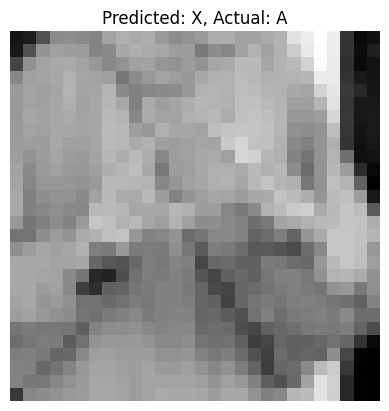

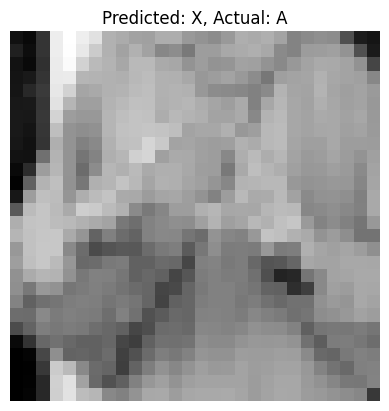

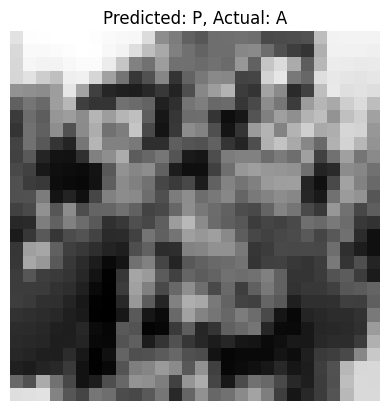

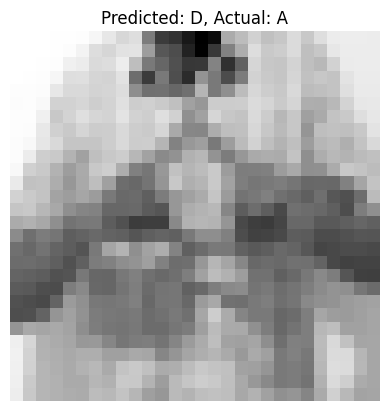

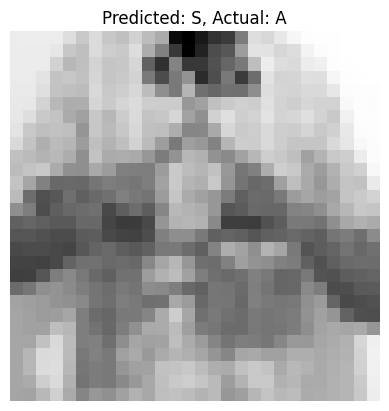

In [12]:
incorrect = evaluate(model, test_loader)

print(len(incorrect))
for i in range(min(5, len(incorrect))):
    img, pred, label = incorrect[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted: {inv_label_mapping[pred.item()]}, Actual: {inv_label_mapping[label.item()]}")
    plt.axis('off')
    plt.show()